In [57]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO: 2016-06-24 13:13:19,683 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [3]:
import glob

In [4]:
fns = glob.glob('/artemis/readout/2016-06-22_2*scan_lo*.nc')
fns.sort()
print len(fns),fns[0],fns[-1]

80 /artemis/readout/2016-06-22_215649_scan_lo_830.0_MHz.nc /artemis/readout/2016-06-22_225431_scan_lo_1400.0_MHz.nc


In [5]:
import pandas as pd

In [6]:
import joblib


In [7]:
memory = joblib.Memory('/home/gjones/pipeline_cache',verbose=0)

In [8]:
parallel = joblib.Parallel(n_jobs=8,verbose=1)

In [9]:
#@memory.cache
def load_sweep_array(fn):
    ncf = NCFile(fn)
    sa = ncf.SweepArray0
    ncf.close()
    return sa.to_dataframe(one_sweep_per_row=False)

In [10]:
rows = parallel([joblib.parallel.delayed(load_sweep_array)(fn) for fn in fns])

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   21.6s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:  2.7min finished


In [11]:
df = pd.concat(rows,ignore_index=True)

In [12]:
df['frequency_MHz'] = df['frequency']/1e6

In [13]:
df.columns

Index([                     u'analysis_epoch',
                                  u'cryostat',
                    u'field_canceling_magnet',
                                 u'frequency',
                         u'hittite_frequency',
                         u'hittite_output_on',
                         u'hittite_power_dBm',
                 u'lockin_detection_harmonic',
                     u'lockin_identification',
                u'lockin_input_configuration',
                     u'lockin_input_coupling',
                 u'lockin_input_notch_filter',
             u'lockin_input_shield_grounding',
                              u'lockin_local',
                u'lockin_output_filter_slope',
                u'lockin_reference_frequency',
                    u'lockin_reference_phase',
                   u'lockin_reference_source',
                  u'lockin_reference_trigger',
                       u'lockin_reserve_mode',
                        u'lockin_rms_voltage',
             

In [26]:
delta = dB(df.iloc[-4].s21_point) -dB(df.iloc[0].s21_point)

In [29]:
from kid_readout.analysis import detect_peaks

In [32]:
peaks = detect_peaks.detect_peaks(np.abs(delta)[:15800],mph=0.15)

In [14]:
f0s = np.sort(np.load('/artemis/readout/resonances/2016-06-24-jpl-hex-271-all-auto-found-resonators.npy'))

In [26]:
def fit_resonators_in_sweep(df_row,f0s,span=(-400e3,100e3)):
    output = []
    row_freq = df_row.frequency
    max_freq = row_freq.max()
    min_freq = row_freq.min()
    for resonator_index,f0 in enumerate(f0s):
        if (f0 > max_freq-span[1]) or (f0 < min_freq-span[0]):
            continue
        data = dict(resonator_index=resonator_index)
        mask = (row_freq > (f0+span[0])) & (row_freq < (f0+span[1]))
        resonator = lmfit_resonator.LinearResonatorWithCable(row_freq[mask],
                                                             df_row.s21_point[mask],
                                                             df_row.s21_point_error[mask])
        for param in resonator.current_result.params.values():
            data['res_{}'.format(param.name)] = param.value
            data['res_{}_error'.format(param.name)] = param.stderr
        data['res_redchi'] = resonator.current_result.redchi
        data['res_Q_i'] = resonator.Q_i
        data['res_Q_e'] = resonator.Q_e
        data['res_s21_data'] = [resonator.data]
        data['res_frequency_data'] = [resonator.frequency]
        data['res_s21_errors'] = [resonator.errors]
        modelf = np.linspace(resonator.frequency.min(), resonator.frequency.max(), 1000)
        models21 = resonator.model.eval(params=resonator.current_params, f=modelf)
        data['res_model_frequency'] = [modelf]
        data['res_model_s21'] = [models21]

        for param in ['lockin_rms_voltage']:
            data[param] = df_row[param]
        output.append(pd.DataFrame(data,index=[0]))
    return pd.concat(output,ignore_index=True)

In [29]:
parallel = joblib.Parallel(n_jobs=8,verbose=1)

In [30]:
frames = parallel([joblib.delayed(fit_resonators_in_sweep)(row,f0s) for k,row in df.iterrows()])

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.5s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:   58.5s finished


In [31]:
dfres = pd.concat(frames,ignore_index=True)

In [41]:
dfres.shape

(4240, 28)

1.72915041696
1.76222228121
1.66620830956
5.29747739764
2.1458668368
1.3450925341
19.7866393664
1.99454627325
3.45047551807
1.1841265955
22.8874864424
2.51605974435


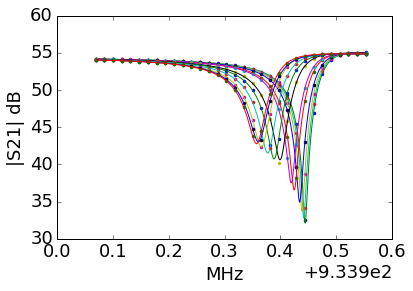

In [93]:
figure()
dd = dfres[(dfres.resonator_index==14) & (dfres.res_redchi < 100)]
for k,row in dd.iterrows():
    plot(row.res_frequency_data/1e6,dB(row.res_s21_data),'.')
    plot(row.res_model_frequency/1e6,dB(row.res_model_s21))
    print row.res_redchi
ylabel('|S21| dB')
xlabel('MHz')

In [78]:
from kid_readout.measurement import mmw_source_sweep

In [83]:
def zbd(x):
    return mmw_source_sweep.zbd_voltage_to_power(mmw_source_sweep.lockin_rms_to_zbd_voltage(x),mmw_frequency=148e9)

In [90]:
rcParams['font.size'] = 18

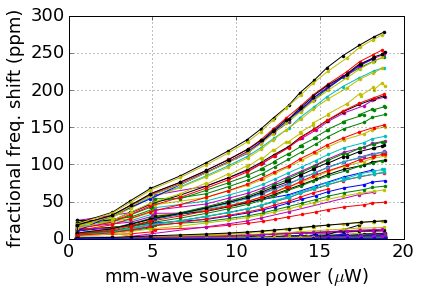

In [91]:
for idx in range(177):
    dd = dfres[(dfres.resonator_index==idx) & (dfres.res_redchi < 10)]
    plot(zbd(dd.lockin_rms_voltage)*1e6,1e6*(dd.res_f_0.max()-dd.res_f_0)/dd.res_f_0.max(),'.-')
xlabel('mm-wave source power ($\mu$W)')
ylabel('fractional freq. shift (ppm)')
grid()

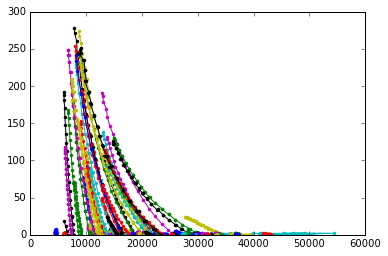

In [70]:
for idx in range(177):
    dd = dfres[(dfres.resonator_index==idx) & (dfres.res_redchi < 10)]
    plot(dd.res_Q,1e6*(dd.res_f_0.max()-dd.res_f_0)/dd.res_f_0.max(),'.-')

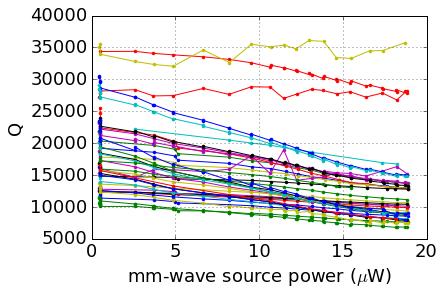

In [92]:
for idx in range(177):
    dd = dfres[(dfres.resonator_index==idx) & (dfres.res_redchi < 10)]
    if dd.res_Q.ptp() > 2e3 and dd.res_Q.max() < 40e3:
        plot(zbd(dd.lockin_rms_voltage)*1e6,dd.res_Q,'.-')
xlabel('mm-wave source power ($\mu$W)')
ylabel('Q')
grid()

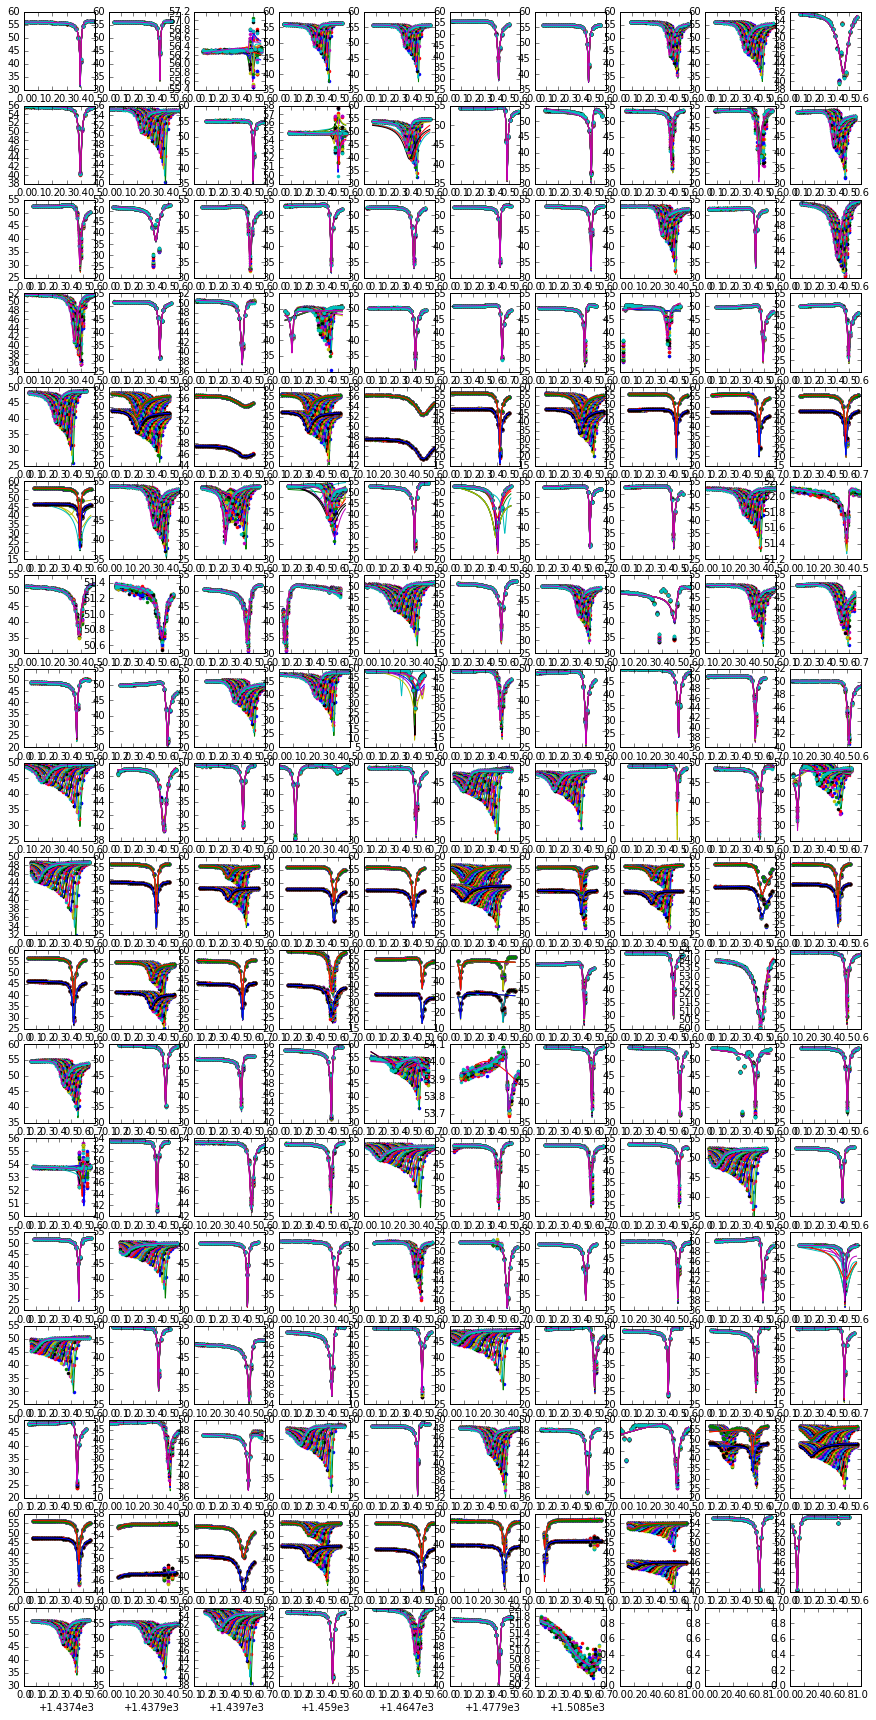

In [59]:
fig,axs = subplots(18,10,figsize=(15,30))
for k in range(177):
    ax = axs.flatten()[k]
    dd = dfres[(dfres.resonator_index==k)]# & (dfres.res_redchi < 10)]
    for m,row in dd.iterrows():
        ax.plot(row.res_frequency_data/1e6,dB(row.res_s21_data),'.')
        ax.plot(row.res_model_frequency/1e6,dB(row.res_model_s21))
        

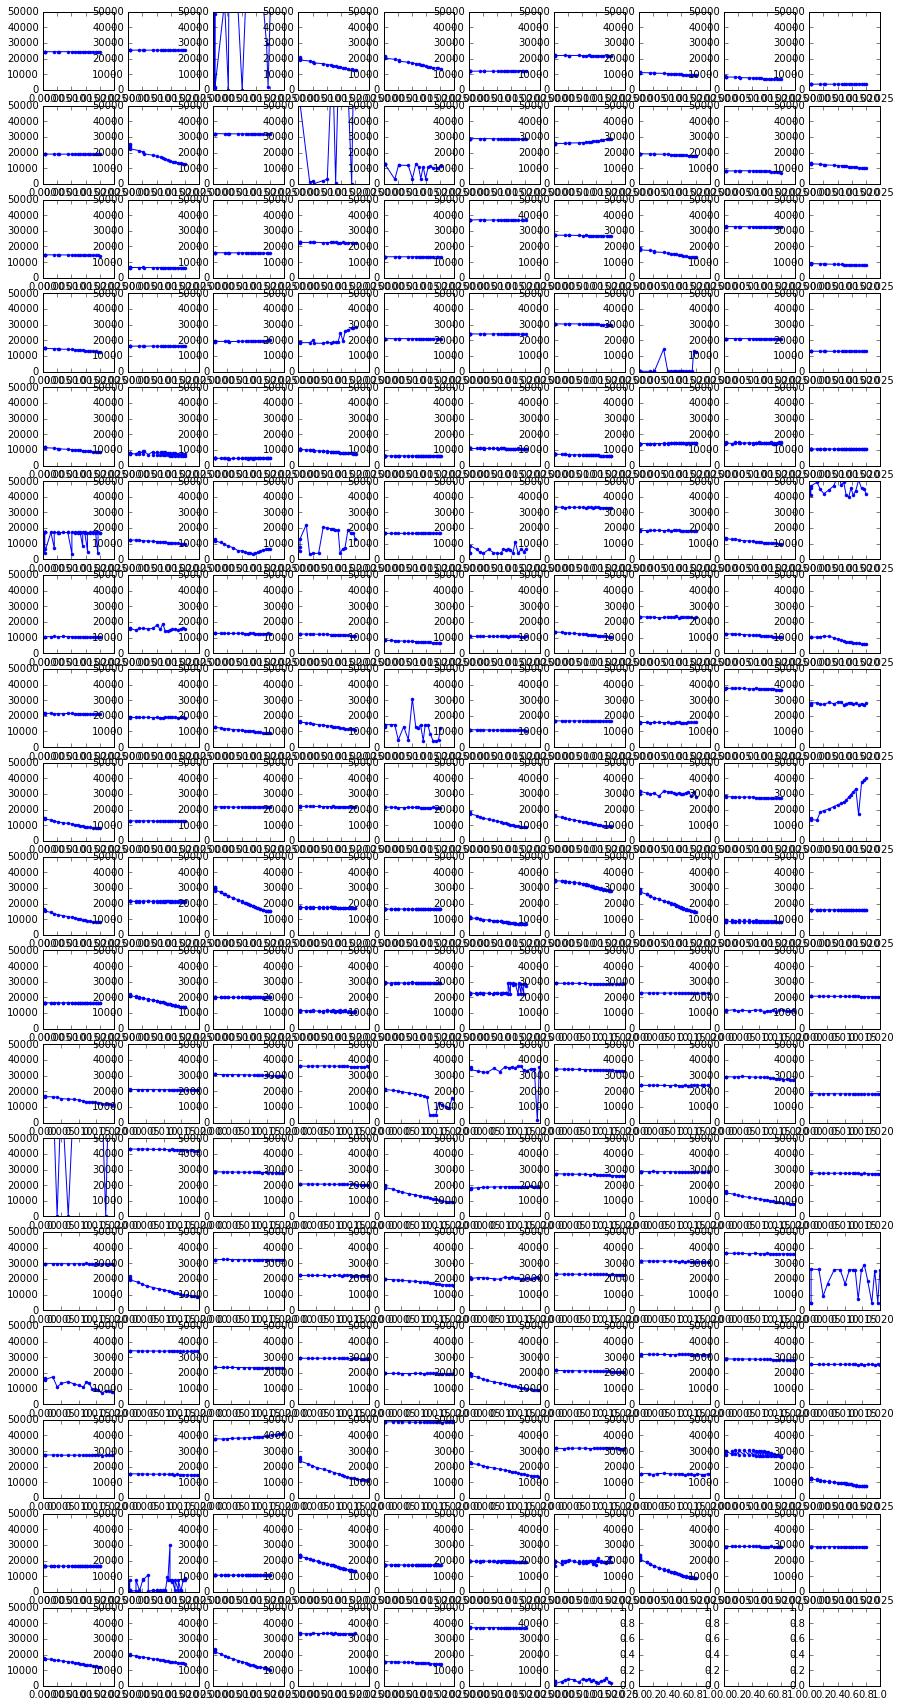

In [60]:
fig,axs = subplots(18,10,figsize=(15,30))
for k in range(177):
    ax = axs.flatten()[k]
    dd = dfres[(dfres.resonator_index==k)]# & (dfres.res_redchi < 10)]
    ax.plot(dd.lockin_rms_voltage,dd.res_Q,'.-')
    ax.set_ylim(0,50e3)
#    for m,row in dd.iterrows():
#        ax.plot(row.res_frequency_data/1e6,dB(row.res_s21_data),'.')
#        ax.plot(row.res_model_frequency/1e6,dB(row.res_model_s21))
        

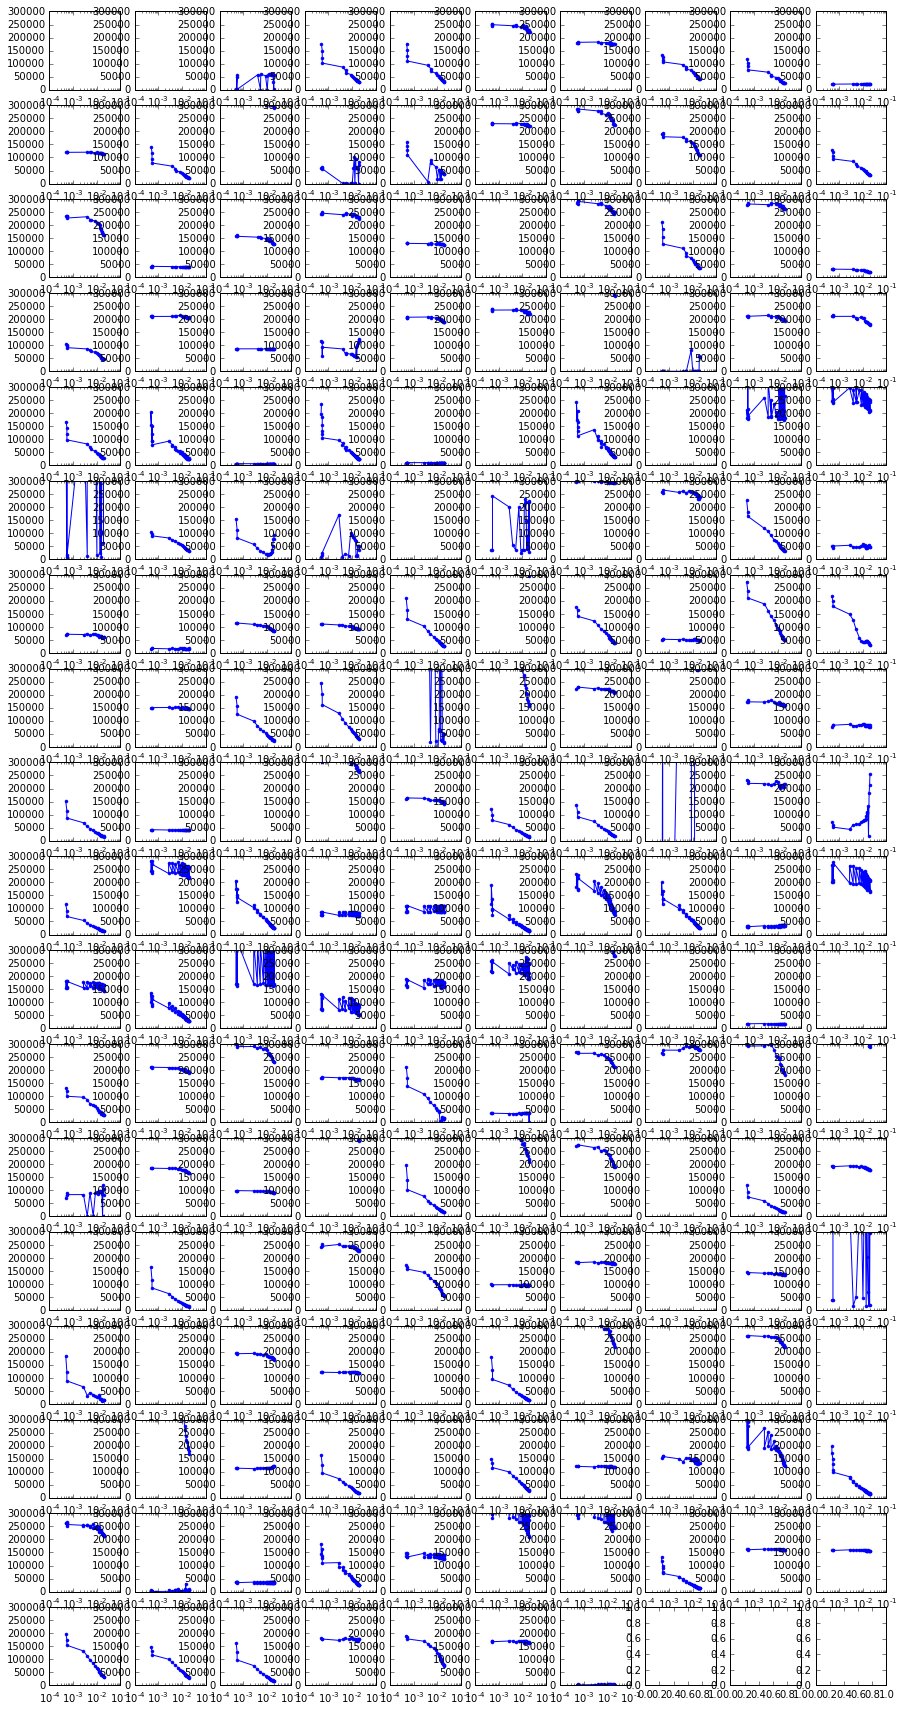

In [62]:
fig,axs = subplots(18,10,figsize=(15,30))
for k in range(177):
    ax = axs.flatten()[k]
    dd = dfres[(dfres.resonator_index==k)]# & (dfres.res_redchi < 10)]
    ax.semilogx(dd.lockin_rms_voltage,dd.res_Q_i,'.-')
    ax.set_ylim(0,300e3)
#    for m,row in dd.iterrows():
#        ax.plot(row.res_frequency_data/1e6,dB(row.res_s21_data),'.')
#        ax.plot(row.res_model_frequency/1e6,dB(row.res_model_s21))
        

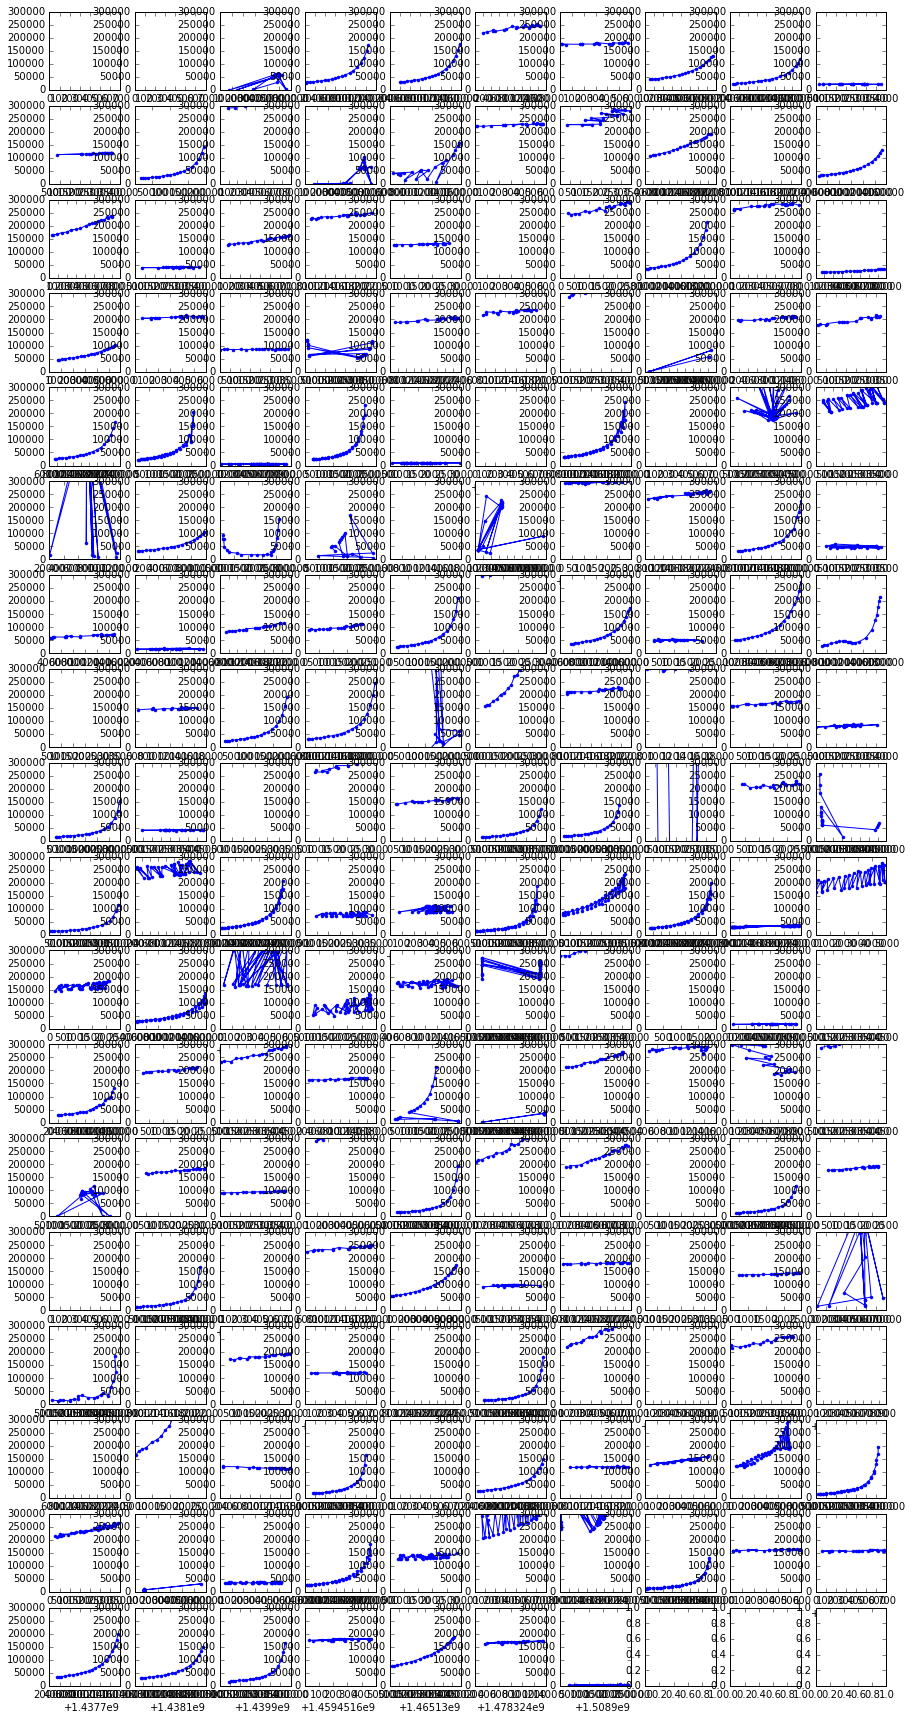

In [64]:
fig,axs = subplots(18,10,figsize=(15,30))
for k in range(177):
    ax = axs.flatten()[k]
    dd = dfres[(dfres.resonator_index==k)]# & (dfres.res_redchi < 10)]
    ax.plot(dd.res_f_0,dd.res_Q_i,'.-')
    ax.set_ylim(0,300e3)
#    for m,row in dd.iterrows():
#        ax.plot(row.res_frequency_data/1e6,dB(row.res_s21_data),'.')
#        ax.plot(row.res_model_frequency/1e6,dB(row.res_model_s21))
        

In [28]:
rows.shape

(51, 28)

In [20]:
len(rows)

51

<IPython.core.display.Javascript object>


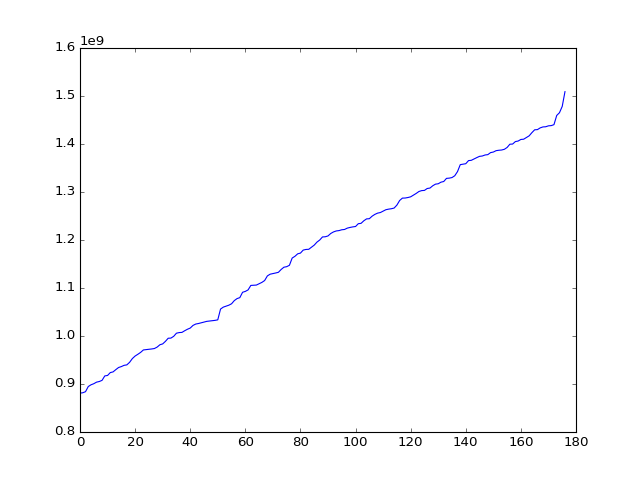

In [37]:
resonator_rows = []
for k,row in df.iterrows():
    for res_idx,f0 in enumerate(f0s):
        

In [ ]:
scipy.spatial.

<IPython.core.display.Javascript object>


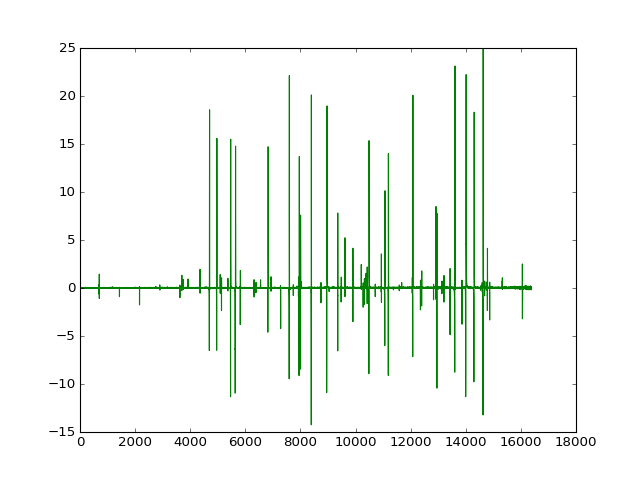

In [24]:
plot(df.lockin_rms_voltage)

<IPython.core.display.Javascript object>


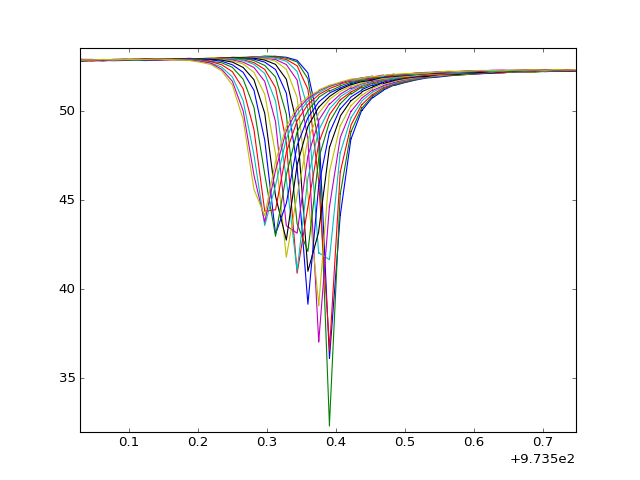

In [21]:
for k,row in df.iterrows():
    if row.frequency_MHz[0]<1000:
        plot(row.frequency_MHz,dB(row.s21_point))

In [14]:
df.shape

(80, 52)

In [12]:
from kid_readout.measurement import mmw_source_sweep

In [22]:
mmw_source_sweep.zbd_voltage_to_power(mmw_source_sweep.lockin_rms_to_zbd_voltage(np.array([.55e-3]),linearize=False),mmw_frequency=148e9)

array([  5.16824352e-07])

<IPython.core.display.Javascript object>


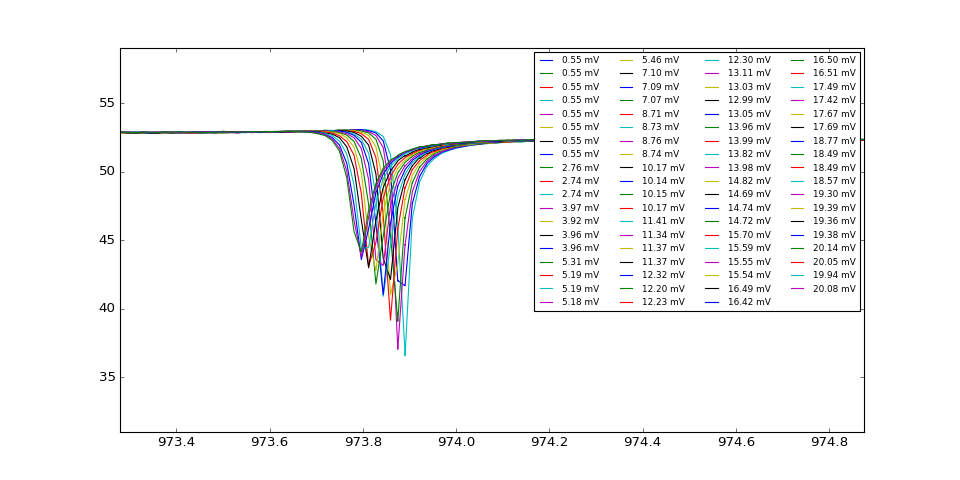

In [18]:
figure(figsize=(12,6))
for sa in sas:
    plot(sa.frequency_MHz, dB(sa.s21_point),label=('%.2f mV' %(sa.state.lockin.rms_voltage*1000)))
legend(loc='upper right',prop=dict(size=8),ncol=4)

In [7]:
ss = sa.stream_arrays[0]

In [12]:
ss.roach_state

StateDict({u'boffile': u'r2iq2xpfb14mcr16gb_2016_Jun_08_1100.bof', u'num_filterbank_channels': 16384, u'loopback': False, u'lo_frequency': 1210000000.0, u'adc_sample_rate': 512000000.0, u'modulation_output': 0, u'waveform_normalization': 0.00213623046875, u'num_tones': 256, u'modulation_rate': 0, u'debug_register': 0, u'dac_attenuation': 20.0, u'num_tone_samples': 32768, u'bank': 0, u'heterodyne': True})

In [7]:
refs = dict([(sa.stream_arrays[0].roach_state['lo_frequency'], sa.s21_point) for sa in sas[3:7]])

In [8]:
refs.keys()

[830000000.0, 1020000000.0, 1210000000.0, 1400000000.0]

<IPython.core.display.Javascript object>


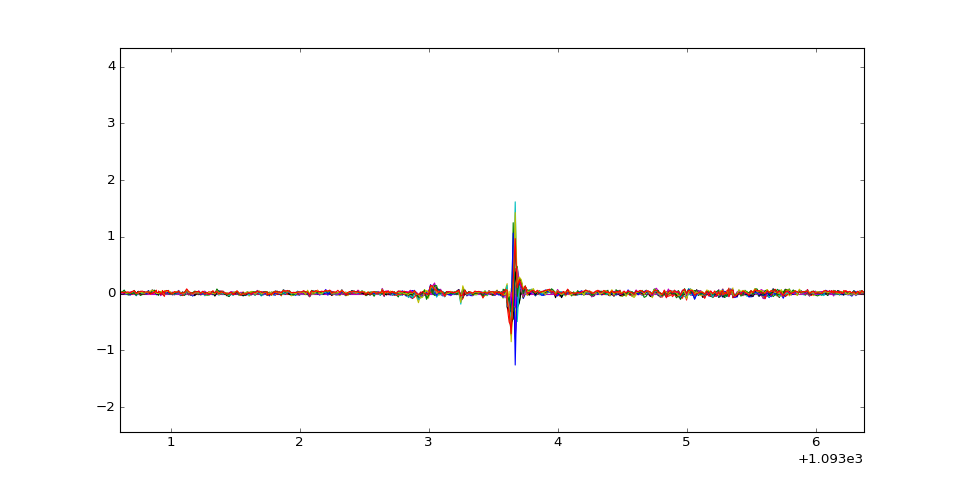

In [9]:
figure(figsize=(12,6))
for sa in sas:
    plot(sa.frequency_MHz, dB(sa.s21_point)-dB(refs[sa.stream_arrays[0].roach_state['lo_frequency']]),label=('%.2f mV' %(sa.state.lockin.rms_voltage*1000)))
#legend(loc='upper right',prop=dict(size=8))

<IPython.core.display.Javascript object>


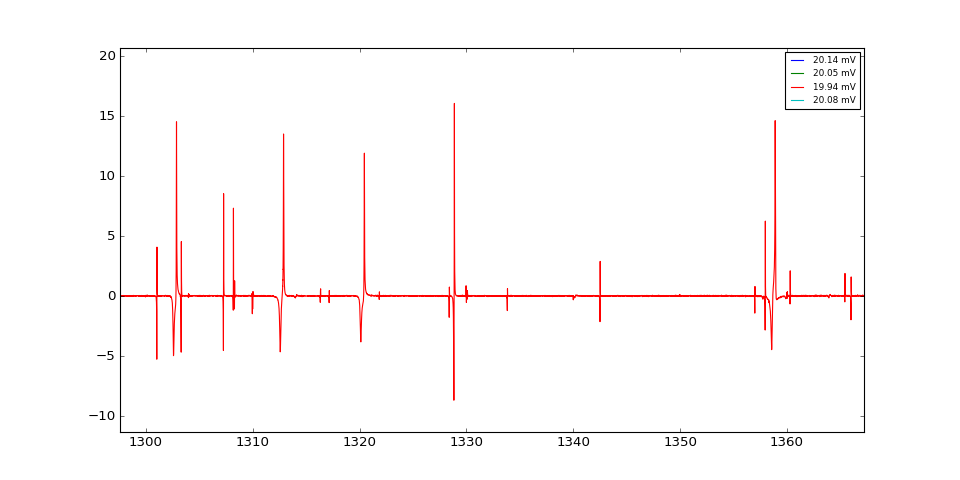

In [10]:
figure(figsize=(12,6))
for sa in sas[-4:]:
    plot(sa.frequency_MHz, dB(sa.s21_point)-dB(refs[sa.stream_arrays[0].roach_state['lo_frequency']]),label=('%.2f mV' %(sa.state.lockin.rms_voltage*1000)))
legend(loc='upper right',prop=dict(size=8))

In [20]:
from kid_readout.analysis import detect_peaks

In [54]:
def remove_duplicates(freqs,tolerance=100e3):
    dropped = 0
    f0s = []
    for f0 in freqs:
        if len(f0s) == 0:
            f0s.append(f0)
            continue
        distance = np.abs(f0-np.array(f0s))
        if not np.any(distance < tolerance):
            f0s.append(f0)
        else:
            dropped +=1
            pass#print "found duplicate of ", f0, "distance", distance.min()
    print "found",dropped,"duplicates"
    return f0s

<IPython.core.display.Javascript object>


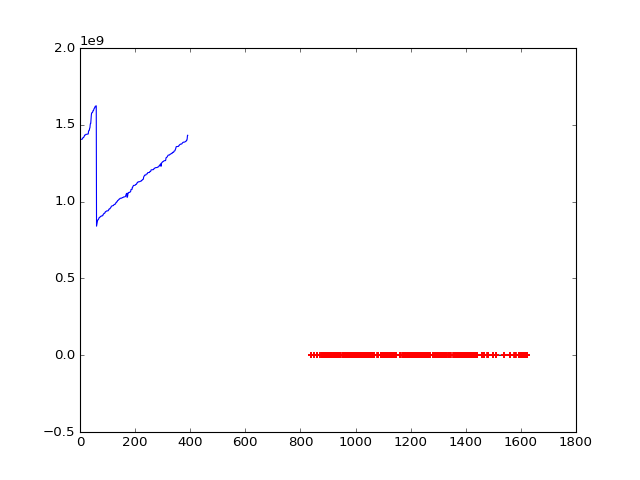

found 210 duplicates
found 413 duplicates
found 648 duplicates
found 587 duplicates
found 66 duplicates


In [55]:
peaks = []
figure()
for sa in sas[-4:]:
    delta = dB(sa.s21_point)-dB(refs[sa.stream_arrays[0].roach_state['lo_frequency']])
    mask = np.abs(delta) > 0.2
#    plot(sa.frequency_MHz,dB(sa.s21_point))
#    plot(sa.frequency_MHz[mask],dB(sa.s21_point[mask]),'r+',mew=1.5)
    plot(sa.frequency_MHz,delta,'k')
    clean = remove_duplicates(sa.frequency[mask])
    plot(clean,delta[mask],'r+',mew=1.5)
    peaks.extend(clean)
peaks = np.array(peaks)
peaks = remove_duplicates(peaks)

<IPython.core.display.Javascript object>


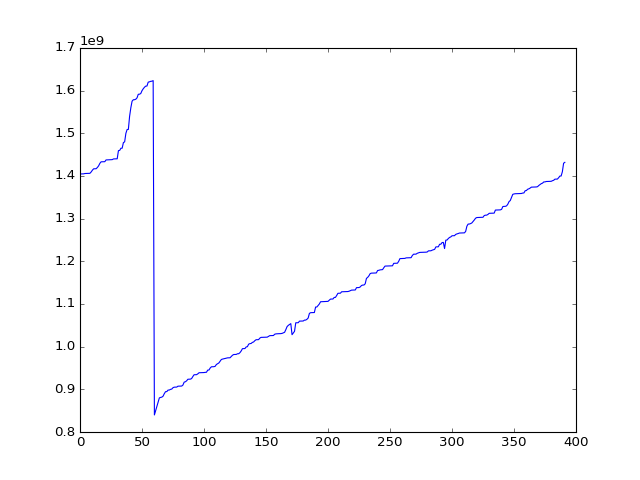

In [59]:
figure()
plot(peaks)

<IPython.core.display.Javascript object>


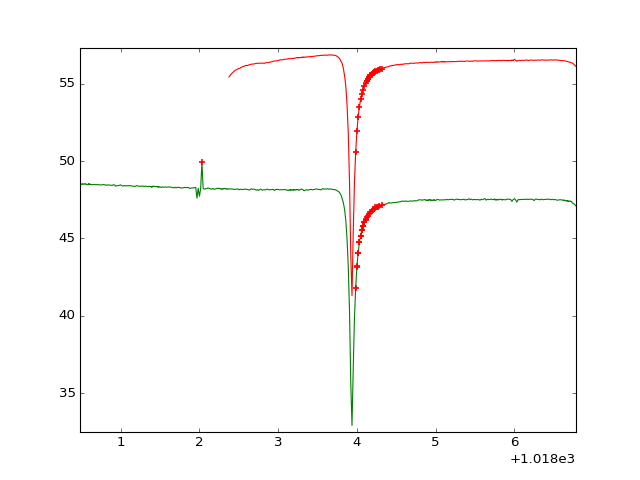

In [53]:
peaks = []
figure()
for sa in sas[-4:]:
    delta = dB(sa.s21_point)-dB(refs[sa.stream_arrays[0].roach_state['lo_frequency']])
    mask = delta > 0.15
    plot(sa.frequency_MHz,dB(sa.s21_point))
    plot(sa.frequency_MHz[mask],dB(sa.s21_point[mask]),'r+',mew=1.5)
#    plot(sa.frequency_MHz,delta,'k')
#    plot(sa.frequency_MHz[mask],delta[mask],'r+',mew=1.5)
    peaks.extend(sa.frequency[mask])
peaks = np.array(peaks)